# Script to preprocess both available datasets
- train-01.txt  (high-quality wayy longer sentences)
- train-02.txt  (moderate-quality wayy shorter sentences)


Update: It seems we don't need this much data, we can just make do with train1 dataset, which is very high quality, and contains around 80M tokens

In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset, DatasetDict, Dataset
import numpy as np
import pandas as pd
import os

c:\Users\Lenovo\miniconda3\envs\assamese\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

In [3]:
MAX_SEQ_LENGTH = 1024  
tokenizer = AutoTokenizer.from_pretrained("unsloth/tinyllama-bnb-4bit")
tokenizer.model_max_length = MAX_SEQ_LENGTH

In [4]:
# Load the dataset
dataset = load_dataset(
    "text", 
    data_files={
    "train1": "datasets/training/train-01.txt",
    "train2": "datasets/training/train-02.txt",
})

## Methods and process dataset
Two process - 
1. simple way, truncating data to max-seq-len
2. using sliding window and less truncation, preserving context

using method 2

In [5]:
# Function to tokenize and get lengths
def get_sequence_lengths(examples):
    # Tokenize with return_length=True, no truncation/padding yet
    tokenized = tokenizer(examples["text"], return_length=True, truncation=False)
    return {"length": tokenized["length"]}


# Function to filter out examples that exceed the max length
def flatten_and_split(examples):  # Use plural for batched input
    flat_texts = []
    for text in examples["text"]:  # Iterate over the list of texts in the batch
        tokenized = tokenizer(text, truncation=False, padding=False, return_tensors="pt")
        input_ids = tokenized["input_ids"][0].tolist()
        chunks = [input_ids[i:i + MAX_SEQ_LENGTH] for i in range(0, len(input_ids), MAX_SEQ_LENGTH)]
        flat_texts.extend([tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks])
    return {"text": flat_texts}

# Function to tokenize and split texts into overlapping chunks
def sliding_window_chunking_no_padding(examples, max_seq_length=1024, overlap=512):
    """
    Tokenizes and splits texts into overlapping chunks without padding.
    
    Args:
        examples: Dictionary containing "text" field with batch of texts.
        max_seq_length: The length of each chunk.
        overlap: Number of tokens to overlap between chunks.

    Returns:
        A dictionary with tokenized and overlapping chunks.
    """
    flat_texts = []

    for text in examples["text"]:
        # Tokenize without truncation
        tokenized = tokenizer(text, truncation=False, padding=False, return_tensors="pt")
        input_ids = tokenized["input_ids"][0].tolist()

        # Sliding window chunking
        step = max_seq_length - overlap
        chunks = [input_ids[i:i + max_seq_length] for i in range(0, len(input_ids), step)]

        # Decode without padding
        flat_texts.extend([tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks])

    return {"text": flat_texts}


# Function to compute length statistics
def compute_length_statistics(lengths, name="Dataset"):
    """Compute and display sequence length statistics."""
    array = np.array(lengths)

    stats = {
        "min": np.min(array),
        "max": np.max(array),
        "mean": np.mean(array),
        "median": np.median(array),
        "percentile_90": np.percentile(array, 90),
        "percentile_95": np.percentile(array, 95),
        "percentile_99": np.percentile(array, 99),
    }

    # Print the statistics
    print(f"\nSequence Length Statistics of {name}:")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")

    return stats


# Function to save DatasetDict splits into Parquet format
def save_datasetdict_to_parquet(dataset_dict, output_dir="parquet_datasets"):
    """Saves a DatasetDict to Parquet format with separate files for each split."""
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    for split_name, dataset in dataset_dict.items():
        output_path = os.path.join(output_dir, f"{split_name}.parquet")
        
        # Save the split to Parquet format
        dataset.to_parquet(output_path)
        
        print(f"Saved {split_name} to {output_path}")

## Process and Tokenize the dataset

In [6]:
# Process each split
print("Processing train1...")
processed_train1 = dataset["train1"].map(sliding_window_chunking_no_padding, batched=True, remove_columns=["text"])
print("Processing train2...")
processed_train2 = dataset["train2"].map(sliding_window_chunking_no_padding, batched=True, remove_columns=["text"])

Processing train1...
Processing train2...


In [7]:
dataset_processed = DatasetDict({
    "processed_train1": processed_train1,
    "processed_train2": processed_train2,
})

print(dataset, dataset_processed)

DatasetDict({
    train1: Dataset({
        features: ['text'],
        num_rows: 12320
    })
    train2: Dataset({
        features: ['text'],
        num_rows: 176608
    })
}) DatasetDict({
    processed_train1: Dataset({
        features: ['text'],
        num_rows: 78495
    })
    processed_train2: Dataset({
        features: ['text'],
        num_rows: 177647
    })
})


In [8]:
# Get the sequence lengths
print("Getting sequence lengths...")
sequence_lengths = dataset.map(get_sequence_lengths, batched=True)
processed_sequence_length = dataset_processed.map(get_sequence_lengths, batched=True)

Getting sequence lengths...


Map: 100%|██████████| 177647/177647 [00:06<00:00, 25883.29 examples/s]


In [9]:
sequence_lengths, processed_sequence_length

(DatasetDict({
     train1: Dataset({
         features: ['text', 'length'],
         num_rows: 12320
     })
     train2: Dataset({
         features: ['text', 'length'],
         num_rows: 176608
     })
 }),
 DatasetDict({
     processed_train1: Dataset({
         features: ['text', 'length'],
         num_rows: 78495
     })
     processed_train2: Dataset({
         features: ['text', 'length'],
         num_rows: 177647
     })
 }))

In [10]:

"""Extract lengths, compute statistics, and display results."""
train1_lengths = sequence_lengths["train1"]["length"]
train2_lengths = sequence_lengths["train2"]["length"]

processed_train1_lengths = processed_sequence_length["processed_train1"]["length"]
processed_train2_lengths = processed_sequence_length["processed_train2"]["length"]

# Combine lengths for overall analysis
all_lengths = train1_lengths + train2_lengths
processed_all_lengths = processed_train1_lengths + processed_train2_lengths

# Display the length counts
print("\nDataset Sizes:")
print(f"Train1 lengths: {len(train1_lengths)}")
print(f"Train2 lengths: {len(train2_lengths)}")
print(f"All lengths: {len(all_lengths)}\n")

print(f"Processed_Train1 lengths: {len(processed_train1_lengths)}")
print(f"Processed_Train2 lengths: {len(processed_train2_lengths)}")
print(f"Processed All lengths: {len(processed_all_lengths)}")


Dataset Sizes:
Train1 lengths: 12320
Train2 lengths: 176608
All lengths: 188928

Processed_Train1 lengths: 78495
Processed_Train2 lengths: 177647
Processed All lengths: 256142


In [11]:
# Compute and display stats
train1_stats = compute_length_statistics(train1_lengths, "Train1")
train2_stats = compute_length_statistics(train2_lengths, "Train2")
all_stats = compute_length_statistics(all_lengths, "All")

processed_train1_stats = compute_length_statistics(processed_train1_lengths, "Processed_Train1")
processed_train2_stats = compute_length_statistics(processed_train2_lengths, "Processed_Train2")
processed_all_stats = compute_length_statistics(processed_all_lengths, "Processed_All")

# print(f"train1_stats: {train1_stats}\ntrain2_stats: {train2_stats}\nall_stats: {all_stats}\n")
# print(f"processed_train1_stats: {processed_train1_stats}\nprocessed_train2_stats: {processed_train2_stats}\nprocessed_all_stats: {processed_all_stats}")


Sequence Length Statistics of Train1:
min: 9.00
max: 86463.00
mean: 3009.57
median: 2220.50
percentile_90: 5781.50
percentile_95: 8155.35
percentile_99: 17882.06

Sequence Length Statistics of Train2:
min: 30.00
max: 842.00
mean: 141.05
median: 105.00
percentile_90: 283.00
percentile_95: 347.00
percentile_99: 472.00

Sequence Length Statistics of All:
min: 9.00
max: 86463.00
mean: 328.11
median: 114.00
percentile_90: 365.00
percentile_95: 1048.65
percentile_99: 4565.92

Sequence Length Statistics of Processed_Train1:
min: 3.00
max: 1027.00
mean: 867.50
median: 1024.00
percentile_90: 1026.00
percentile_95: 1026.00
percentile_99: 1026.00

Sequence Length Statistics of Processed_Train2:
min: 3.00
max: 842.00
mean: 140.62
median: 105.00
percentile_90: 282.00
percentile_95: 346.00
percentile_99: 472.00

Sequence Length Statistics of Processed_All:
min: 3.00
max: 1027.00
mean: 363.37
median: 160.00
percentile_90: 1025.00
percentile_95: 1026.00
percentile_99: 1026.00


## Save the Processed Datasets

In [12]:
# processed_train1, processed_train2
# Save the processed dataset to Parquet
OUTPUT_RAW = "datasets/training"
OUTPUT_DIR = "datasets/processed"

save_datasetdict_to_parquet(dataset, output_dir=OUTPUT_RAW)
save_datasetdict_to_parquet(dataset_processed, output_dir=OUTPUT_DIR)


Creating parquet from Arrow format: 100%|██████████| 13/13 [00:00<00:00, 74.82ba/s]


Saved train1 to datasets/training\train1.parquet


Creating parquet from Arrow format: 100%|██████████| 177/177 [00:00<00:00, 1125.01ba/s]


Saved train2 to datasets/training\train2.parquet


Creating parquet from Arrow format: 100%|██████████| 79/79 [00:00<00:00, 336.74ba/s]


Saved processed_train1 to datasets/processed\processed_train1.parquet


Creating parquet from Arrow format: 100%|██████████| 178/178 [00:00<00:00, 1351.56ba/s]

Saved processed_train2 to datasets/processed\processed_train2.parquet


In [13]:
# Load train1.parquet
train1_parquet = load_dataset("parquet", data_files=f"{OUTPUT_RAW}/train1.parquet")

# Load train2.parquet
train2_parquet = load_dataset("parquet", data_files=F"{OUTPUT_RAW}/train2.parquet")

# Load train1.parquet
processed_train1_parquet = load_dataset("parquet", data_files=f"{OUTPUT_DIR}/processed_train1.parquet")

# Load train2.parquet
processed_train2_parquet = load_dataset("parquet", data_files=F"{OUTPUT_DIR}/processed_train2.parquet")

tr1 = (len(train1_lengths) == train1_parquet["train"].shape[0])
tr2 = (len(train2_lengths) == train2_parquet["train"].shape[0])
ptr1 = (len(processed_train1_lengths) == processed_train1_parquet["train"].shape[0])
ptr2 = (len(processed_train2_lengths) == processed_train2_parquet["train"].shape[0])

del train1_parquet, train2_parquet, processed_train1_parquet, processed_train2_parquet

print("Verify all load correctly\n")
print(f"Train1: {tr1}\nTrain2: {tr2}\nProcessed Train1: {ptr1}\nProcessed Train2: {ptr2}")

Generating train split: 12320 examples [00:00, 106006.29 examples/s]
Generating train split: 176608 examples [00:00, 1801039.27 examples/s]
Generating train split: 78495 examples [00:00, 571615.90 examples/s]
Generating train split: 177647 examples [00:00, 1891389.99 examples/s]

Verify all load correctly

Train1: True
Train2: True
Processed Train1: True
Processed Train2: True


## Visualize stats

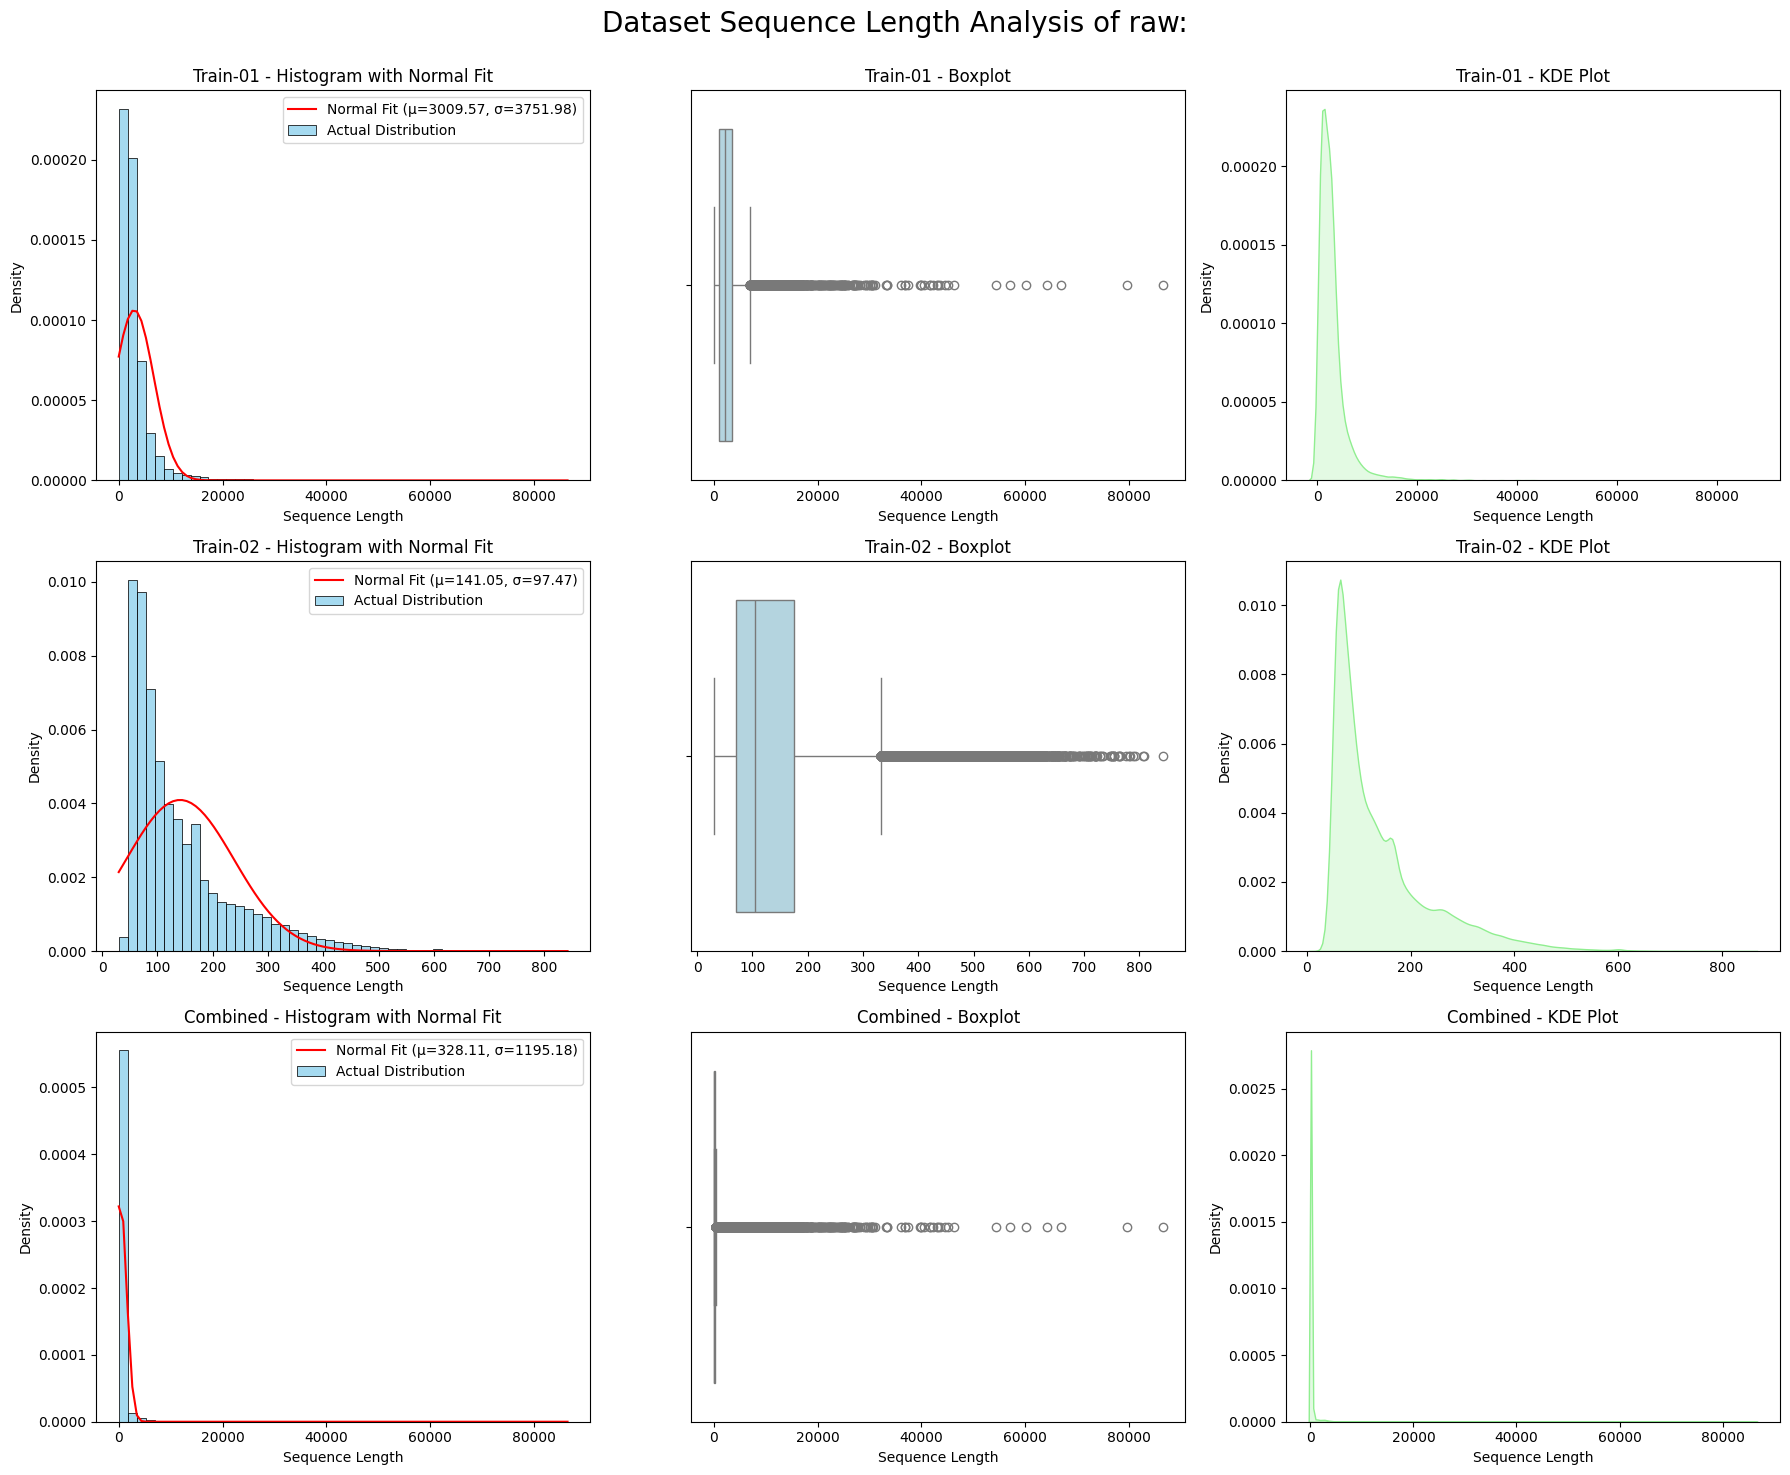

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Dataset Sequence Length Analysis of raw:', fontsize=20)

# --- Histogram + Normal Distribution ---
def plot_histogram_with_normal(ax, data, title):
    sns.histplot(data, bins=50, kde=False, ax=ax, color='skyblue', stat='density', label='Actual Distribution')
    
    # Fit and plot a normal distribution
    mu, std = norm.fit(data)
    x = np.linspace(min(data), max(data), 100)
    p = norm.pdf(x, mu, std)
    
    ax.plot(x, p, 'r-', label=f'Normal Fit (μ={mu:.2f}, σ={std:.2f})')
    ax.set_title(title)
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Density')
    ax.legend()

# --- Boxplot ---
def plot_boxplot(ax, data, title):
    sns.boxplot(x=data, ax=ax, color='lightblue')
    ax.set_title(title)
    ax.set_xlabel('Sequence Length')

# --- KDE Plot ---
def plot_kde(ax, data, title):
    sns.kdeplot(data, fill=True, ax=ax, color='lightgreen')
    ax.set_title(title)
    ax.set_xlabel('Sequence Length')

# --- Combined Plotting ---
datasets = [
    (train1_lengths, "Train-01"),
    (train2_lengths, "Train-02"),
    (all_lengths, "Combined")
]

for i, (data, name) in enumerate(datasets):
    # Histogram + Normal
    plot_histogram_with_normal(axes[i, 0], data, f"{name} - Histogram with Normal Fit")
    
    # Boxplot
    plot_boxplot(axes[i, 1], data, f"{name} - Boxplot")
    
    # KDE Plot
    plot_kde(axes[i, 2], data, f"{name} - KDE Plot")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

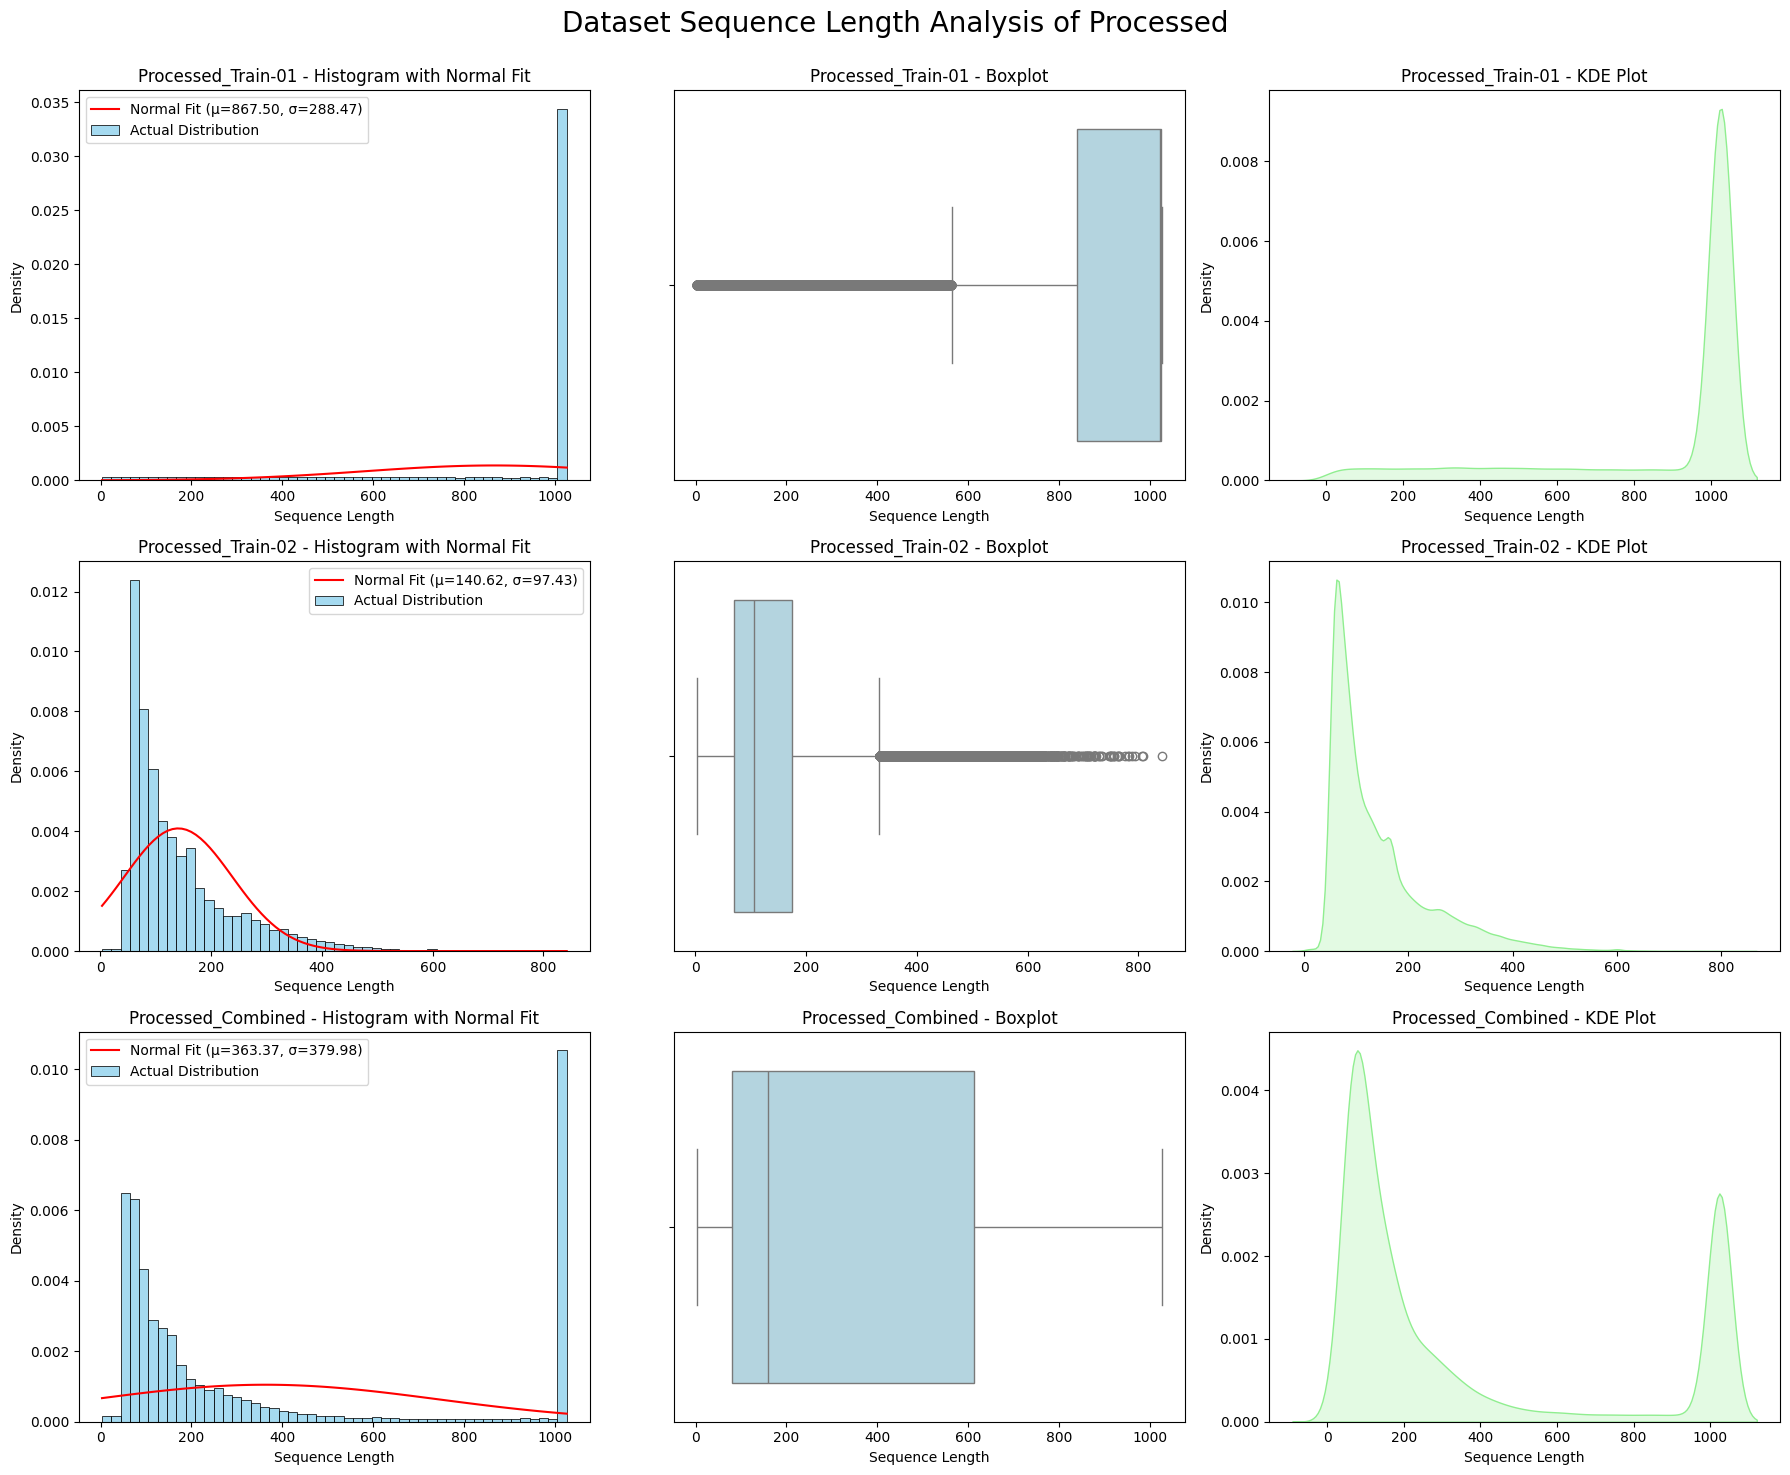

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Dataset Sequence Length Analysis of Processed', fontsize=20)

datasets = [
    (processed_train1_lengths, "Processed_Train-01"),
    (processed_train2_lengths, "Processed_Train-02"),
    (processed_all_lengths, "Processed_Combined")
]

for i, (data, name) in enumerate(datasets):
    # Histogram + Normal
    plot_histogram_with_normal(axes[i, 0], data, f"{name} - Histogram with Normal Fit")
    
    # Boxplot
    plot_boxplot(axes[i, 1], data, f"{name} - Boxplot")
    
    # KDE Plot
    plot_kde(axes[i, 2], data, f"{name} - KDE Plot")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

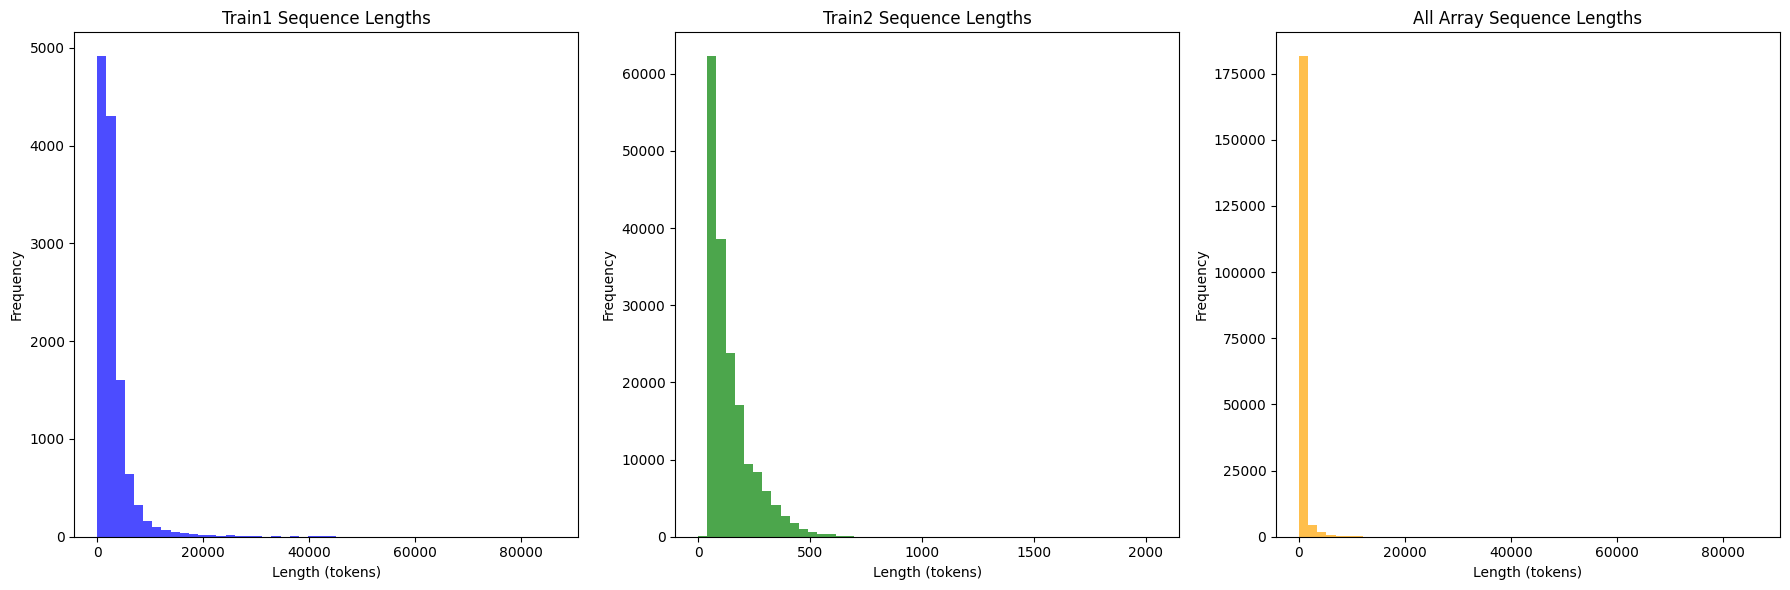

In [16]:
# Plotting histograms with individual ranges
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train1 Histogram
axes[0].hist(train1_lengths, bins=50, range=(0, max(2048, train1_stats["max"])), color='blue', alpha=0.7)
axes[0].set_title("Train1 Sequence Lengths")
axes[0].set_xlabel("Length (tokens)")
axes[0].set_ylabel("Frequency")

# Train2 Histogram
axes[1].hist(train2_lengths, bins=50, range=(0, max(2048, train2_stats["max"])), color='green', alpha=0.7)
axes[1].set_title("Train2 Sequence Lengths")
axes[1].set_xlabel("Length (tokens)")
axes[1].set_ylabel("Frequency")

# All Array Histogram
axes[2].hist(all_lengths, bins=50, range=(0, max(2048, all_stats["max"])), color='orange', alpha=0.7)
axes[2].set_title("All Array Sequence Lengths")
axes[2].set_xlabel("Length (tokens)")
axes[2].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

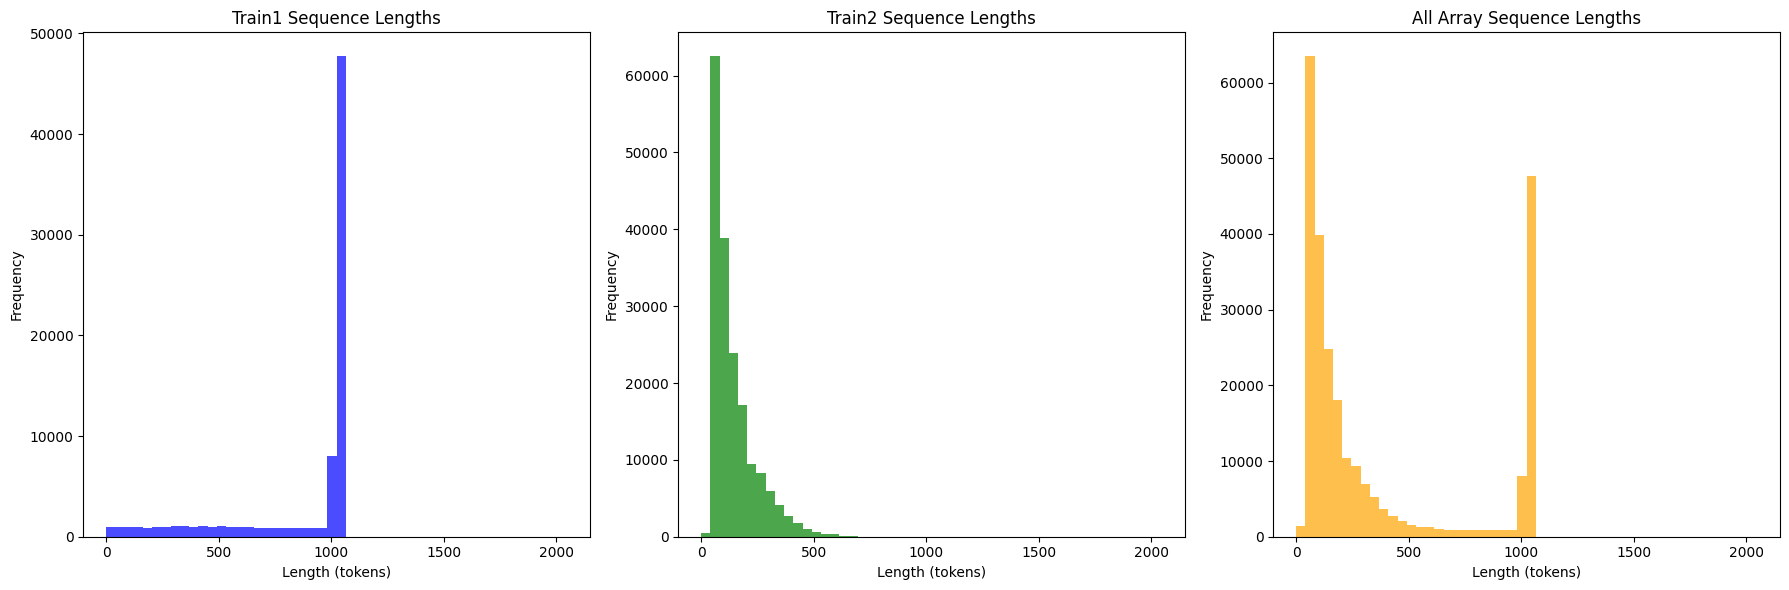

In [17]:
# Plotting histograms with individual ranges
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train1 Histogram
axes[0].hist(processed_train1_lengths, bins=50, range=(0, max(2048, processed_train1_stats["max"])), color='blue', alpha=0.7)
axes[0].set_title("Train1 Sequence Lengths")
axes[0].set_xlabel("Length (tokens)")
axes[0].set_ylabel("Frequency")

# Train2 Histogram
axes[1].hist(processed_train2_lengths, bins=50, range=(0, max(2048, processed_train2_stats["max"])), color='green', alpha=0.7)
axes[1].set_title("Train2 Sequence Lengths")
axes[1].set_xlabel("Length (tokens)")
axes[1].set_ylabel("Frequency")

# All Array Histogram
axes[2].hist(processed_all_lengths, bins=50, range=(0, max(2048, processed_all_stats["max"])), color='orange', alpha=0.7)
axes[2].set_title("All Array Sequence Lengths")
axes[2].set_xlabel("Length (tokens)")
axes[2].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

## Combine and create train and val
- take 5% from both processed train1 and processed train 2 and combine to for val and rest for training

In [18]:
val_ratio = 0.05  # 5% of the data from each for validation

# Split without shuffling (context preserved)
val_size1 = int(len(processed_train1["text"]) * val_ratio)
train1_train = processed_train1["text"][:-val_size1]   # 90% for training
train1_val = processed_train1["text"][-val_size1:]     # 10% for validation

val_size2 = int(len(processed_train2["text"]) * val_ratio)
train2_train = processed_train2["text"][:-val_size2]   # 90% for training
train2_val = processed_train2["text"][-val_size2:]     # 10% for validation

# Combine datasets (no shuffling, context preserved)
train = train1_train + train2_train
val = train1_val + train2_val

In [19]:
combined_dataset = {
    "train": Dataset.from_dict({"text": train}),
    "val": Dataset.from_dict({"text": val})
}

# Save the DatasetDict to Parquet format
save_datasetdict_to_parquet(combined_dataset, output_dir=OUTPUT_DIR)

Creating parquet from Arrow format: 100%|██████████| 244/244 [00:00<00:00, 799.44ba/s]


Saved train to datasets/processed\train.parquet


Creating parquet from Arrow format: 100%|██████████| 13/13 [00:00<00:00, 792.21ba/s]

Saved val to datasets/processed\val.parquet


In [20]:
# Load train2.parquet
train_parquet = load_dataset("parquet", data_files=F"{OUTPUT_DIR}/train.parquet")
val_parquet = load_dataset("parquet", data_files=F"{OUTPUT_DIR}/val.parquet")

# Verify the lengths
tr = (train_parquet["train"].shape[0] == len(train))
vl = (val_parquet["train"].shape[0] == len(val))

del train_parquet
del val_parquet

print("Verify all load correctly\n")
print(f"Train: {tr}, {len(train)}\nVal: {vl}, {len(val)}")

Generating train split: 243336 examples [00:00, 1045479.34 examples/s]
Generating train split: 12806 examples [00:00, 767668.89 examples/s]

Verify all load correctly

Train: True, 243336
Val: True, 12806
